# Resnet Exploration

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchinfo import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

from local.model import save_model, load_model, reset_model
from local.imagenet import train_data, eval_data, train_model, eval_model
from local.resnet import resnets, resnet18, resnet34, resnet50, resnet101, resnet152
from local.device import device, cpu


print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
print("Pytorch device: ", device)


/Users/marakim/opt/anaconda3/envs/network_inflation/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/marakim/opt/anaconda3/envs/network_inflation/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: <BE0CCD9A-269A-30E2-A23C-DA45E89EBB1F> /Users/marakim/opt/anaconda3/envs/network_inflation/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marakim/opt/anaconda3/envs/network_inflation/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/Users/marakim/opt/anaconda3/envs/network_inflation/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/Users/marakim/opt/anaconda3/envs/network_inflation/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/Users/marakim/opt/anaconda3/envs/network_inflation/bin/../lib/libjpeg.8.dylib' (no such file), '/System/Vol

PyTorch Version:  1.13.1
Torchvision Version:  0.14.1a0
Pytorch device:  mps


In [2]:
# training_data = torchvision.datasets.ImageNet('~/Documents/research/imagenet/', split="train", transform=preprocess)
data_root = '~/Documents/research/imagenet/ILSVRC/Data/CLS-LOC/train/'

train_data = train_data(data_root)
eval_data = eval_data(data_root)

In [3]:
dict(resnet18.named_parameters()).keys()
dict(resnet18.named_parameters())['layer4.0.conv2.weight'][0,0]


tensor([[ 0.0002, -0.0147, -0.0170],
        [-0.0129, -0.0331, -0.0367],
        [ 0.0278,  0.0177, -0.0184]], grad_fn=<SelectBackward0>)

In [4]:
load_model(resnet18, "resnet18")

In [5]:
eval_model(resnet152, eval_data)

  0%|          | 18/20019 [01:18<24:22:08,  4.39s/it]


KeyboardInterrupt: 

In [7]:
train_model(resnet152, "resnet152.pretrained", train_data)

  0%|          | 0/5005 [00:00<?, ?it/s]/Users/marakim/opt/anaconda3/envs/network_inflation/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/marakim/opt/anaconda3/envs/network_inflation/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: <BE0CCD9A-269A-30E2-A23C-DA45E89EBB1F> /Users/marakim/opt/anaconda3/envs/network_inflation/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marakim/opt/anaconda3/envs/network_inflation/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/Users/marakim/opt/anaconda3/envs/network_inflation/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/Users/marakim/opt/anaconda3/envs/network_inflation/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/Users/marakim/opt/anaconda3/envs/network_inflation/bin/../lib/libjp

KeyboardInterrupt: 

In [8]:
list(map(
    lambda x: x.eval(),
    resnets
))
"Eval mode"

'Eval mode'

In [9]:
summary(resnet18, [1, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

In [ ]:
[x for x,_ in resnet50.named_parameters()]

In [19]:
list(map(
    lambda x: x.to(cpu) and x.conv1,
    resnets
))

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)]

In [18]:
def cosine_similarity(weight0, weight1):
    cos = nn.functional.cosine_similarity
    return torch.stack(tuple(
        cos(
            weight0[idx].expand(weight1.shape),
            weight1,
        )
        for idx in range(weight0.shape[0])
    ))


def histogram(input, bins=100, range=(0,1), width=1):
    histogram = input.histogram(bins=bins,range=range)
    plt.bar(
        x=histogram.bin_edges[:-1].detach(),
        height=histogram.hist.detach(),
        width=width*(range[1]-range[0])/bins,
        align='edge')

def random_unit(shape):
    return torch.normal(torch.zeros(shape), torch.ones(shape))

def self_similarity(network0):
    weight0 = network0.conv1.get_parameter('weight').flatten(start_dim=1)
    measure = cosine_similarity(weight0, weight0).fill_diagonal_(0).abs().max(dim=1).values
    histogram(measure)

def similarity(network0, network1):
    measure = cosine_similarity(
        network0.conv1.get_parameter('weight').flatten(start_dim=1),
        network1.conv1.get_parameter('weight').flatten(start_dim=1),
    ).abs().max(dim=1).values
    histogram(measure)

def null_similarity(network0):
    weight0 = network0.conv1.get_parameter('weight').flatten(start_dim=1)
    measure = torch.stack([
        cosine_similarity(
            weight0,
            random_unit(weight0.shape)
        ).abs().max(dim=1).values
        for _ in range(2048)
    ])
    histogram(measure, bins=1000)


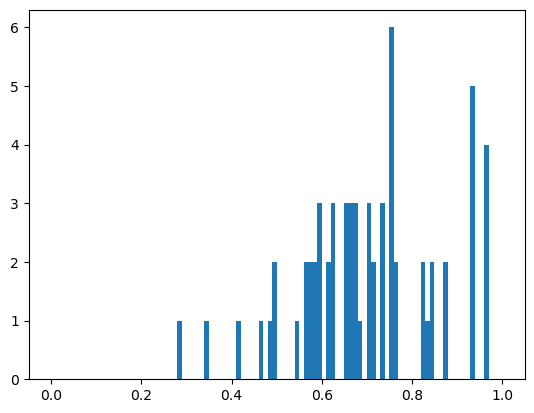

In [24]:
self_similarity(resnet50)

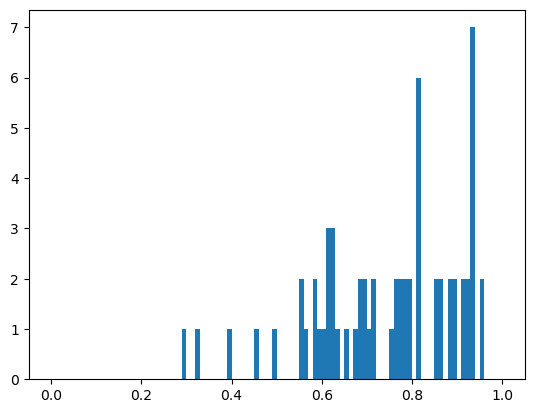

In [25]:
self_similarity(resnet101)

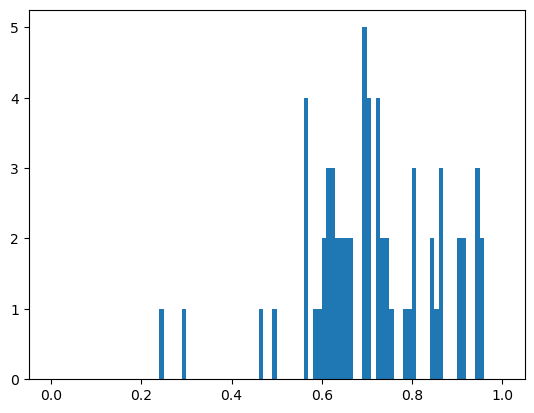

In [26]:
self_similarity(resnet152)

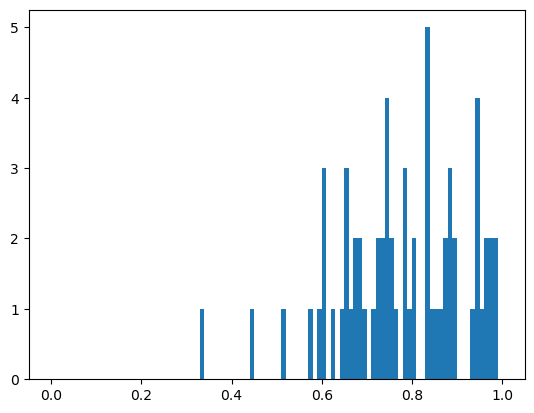

In [31]:
similarity(resnet50, resnet152)

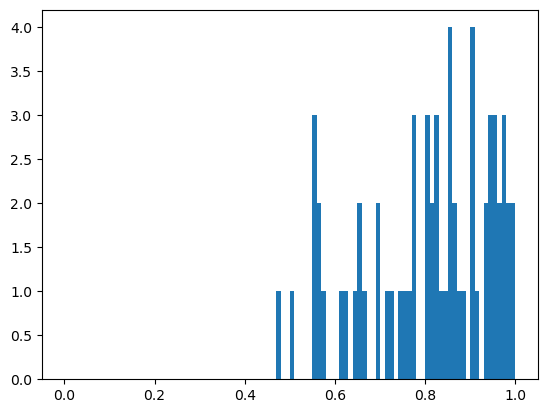

In [36]:
similarity(resnet101, resnet152)


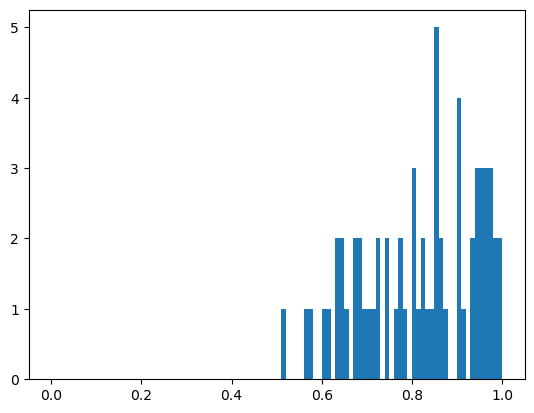

In [35]:
similarity(resnet152, resnet101)

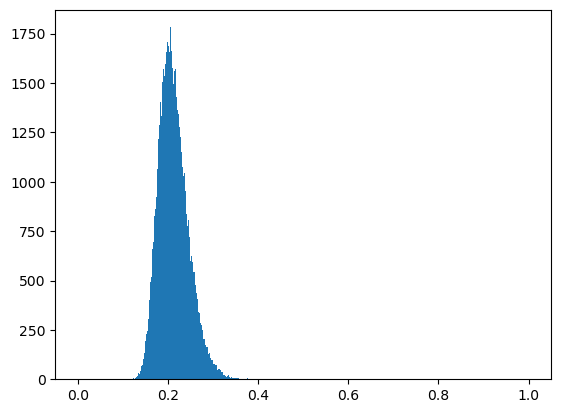

In [32]:
null_similarity(resnet50)


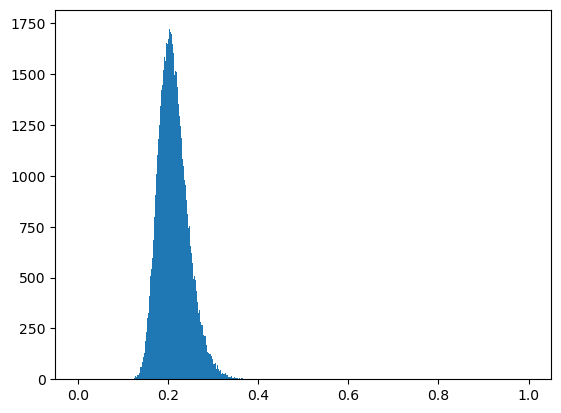

In [34]:
null_similarity(resnet101)

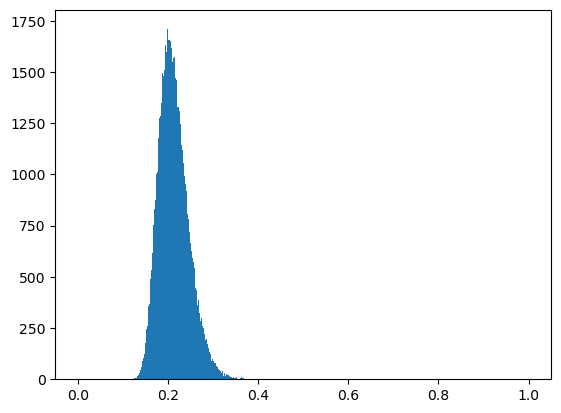

In [ ]:
null_similarity(resnet152)
